# Variational Auto-encoders for anime faces
Reference: https://learnopencv.com/variational-autoencoder-in-tensorflow/#network-fmnist

In [2]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download andrewmvd/animal-faces
! unzip animal-faces

Streaming output truncated to the last 5000 lines.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/fl

In [3]:
import os
import time
#import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
img_height, img_width = 256, 256
#batch_size = 128 reducing for the sake of memory
batch_size = 128

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'afhq/train/',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

Found 14630 files belonging to 1 classes.


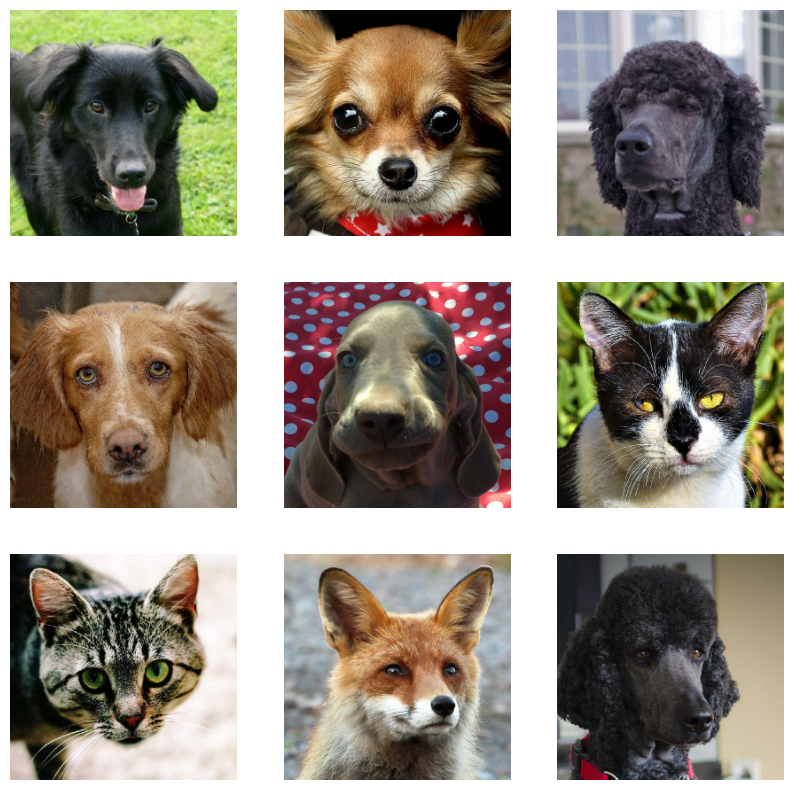

In [7]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [9]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [10]:
print(np.min(first_image), np.max(first_image))

0.0029411768 0.9833334


In [11]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    #reparametrization trick
    return mean + K.exp(log_var / 2) * epsilon

In [12]:
input_encoder = tuple(first_image.shape)
input_decoder = (200,)

In [13]:
'''def encoder(input_encoder):
    inputs = keras.Input(shape=input_encoder, name='input_layer')

    # Block-1
    x = layers.Conv2D(128, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.ReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.ReLU(name='lrelu_2')(x)
    x = layers.Dropout(0.2)(x)

    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.ReLU(name='lrelu_3')(x)

    # Block-4

    x = layers.Conv2D(32, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.ReLU(name='lrelu_4')(x)


    # Final Block
    flatten = layers.Flatten()(x)
    mean = layers.Dense(200, name='mean')(flatten)
    log_var = layers.Dense(200, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model'''

'def encoder(input_encoder):\n    inputs = keras.Input(shape=input_encoder, name=\'input_layer\')\n\n    # Block-1\n    x = layers.Conv2D(128, kernel_size=3, strides= 2, padding=\'same\', name=\'conv_1\')(inputs)\n    x = layers.BatchNormalization(name=\'bn_1\')(x)\n    x = layers.ReLU(name=\'lrelu_1\')(x)\n\n    # Block-2\n    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding=\'same\', name=\'conv_2\')(x)\n    x = layers.BatchNormalization(name=\'bn_2\')(x)\n    x = layers.ReLU(name=\'lrelu_2\')(x)\n    x = layers.Dropout(0.2)(x)\n\n    # Block-3\n    x = layers.Conv2D(64, 3, 2, padding=\'same\', name=\'conv_3\')(x)\n    x = layers.BatchNormalization(name=\'bn_3\')(x)\n    x = layers.ReLU(name=\'lrelu_3\')(x)\n\n    # Block-4\n\n    x = layers.Conv2D(32, 3, 2, padding=\'same\', name=\'conv_4\')(x)\n    x = layers.BatchNormalization(name=\'bn_4\')(x)\n    x = layers.ReLU(name=\'lrelu_4\')(x)\n\n\n    # Final Block\n    flatten = layers.Flatten()(x)\n    mean = layers.Dense(200, 

In [14]:
def encoder(input_encoder):
    inputs = keras.Input(shape=input_encoder, name='input_layer')

    # Block-1
    x = layers.Conv2D(128, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    x = layers.Dropout(0.2)(x)

    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Block-4

    x = layers.Conv2D(32, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)


    # Final Block
    flatten = layers.Flatten()(x)
    mean = layers.Dense(200, name='mean')(flatten)
    log_var = layers.Dense(200, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [15]:
enc = encoder(input_encoder)

In [16]:
#enc.summary()

In [17]:
input_1 = (200,)
input_2 = (200,)

In [18]:
def sampling(input_1,input_2):
    #input1 = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [19]:
final = sampling(input_1,input_2)

In [20]:
final.save('sampling-anime.h5')

In [21]:
'''def decoder(input_decoder):

    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8,8,64), name='Reshape')(x)

    # Block-1
    x = layers.Conv2DTranspose(32, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.ReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.ReLU(name='lrelu_2')(x)

    # Block-3
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.ReLU(name='lrelu_3')(x)

    # Block-4
    x = layers.Conv2DTranspose(128, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.ReLU(name='lrelu_4')(x)


    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model'''

'def decoder(input_decoder):\n\n    inputs = keras.Input(shape=input_decoder, name=\'input_layer\')\n    x = layers.Dense(4096, name=\'dense_1\')(inputs)\n    x = layers.Reshape((8,8,64), name=\'Reshape\')(x)\n\n    # Block-1\n    x = layers.Conv2DTranspose(32, 3, strides= 2, padding=\'same\',name=\'conv_transpose_1\')(x)\n    x = layers.BatchNormalization(name=\'bn_1\')(x)\n    x = layers.ReLU(name=\'lrelu_1\')(x)\n\n    # Block-2\n    x = layers.Conv2DTranspose(64, 3, strides= 2, padding=\'same\', name=\'conv_transpose_2\')(x)\n    x = layers.BatchNormalization(name=\'bn_2\')(x)\n    x = layers.ReLU(name=\'lrelu_2\')(x)\n\n    # Block-3\n    x = layers.Conv2DTranspose(64, 3, 2, padding=\'same\', name=\'conv_transpose_3\')(x)\n    x = layers.BatchNormalization(name=\'bn_3\')(x)\n    x = layers.ReLU(name=\'lrelu_3\')(x)\n\n    # Block-4\n    x = layers.Conv2DTranspose(128, 3, 2, padding=\'same\', name=\'conv_transpose_4\')(x)\n    x = layers.BatchNormalization(name=\'bn_4\')(x)\n    x 

In [22]:
def decoder(input_decoder):

    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8,8,64), name='Reshape')(x)

    # Block-1
    x = layers.Conv2DTranspose(32, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)

    # Block-3
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Block-4
    x = layers.Conv2DTranspose(128, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)


    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [23]:
from functools import lru_cache

def get_optimizer(optimizer_type,lr):
    #choosing a not so fast learning rate but also not super slow, dont have the time to experiment with different learning
    #rates
    if optimizer_type == 0:
        return tf.keras.optimizers.legacy.Adam(learning_rate =lr)
    elif optimizer_type == 1:
        return tf.keras.optimizers.legacy.SGD(learning_rate = lr)
    elif optimizer_type == 3:
        return tf.keras.optimizers.legacy.AdamW(learning_rate=lr)
    elif optimizer_type == 2:
        return tf.keras.optimizers.legacy.Nadam(learning_rate=lr)
    elif optimizer_type == 4:
        return tf.keras.optimizers.legacy.Yogi(learning_rate=lr)


def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_inception_score(p_yx, eps=1E-16):
    p_y = np.expand_dims(np.mean(p_yx, axis=0), 0)
    kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
    sum_kl_d = kl_d.sum(axis=1)

    avg_kl_d = np.mean(sum_kl_d)
    is_score = np.exp(avg_kl_d)
    return is_score


In [24]:
dec = decoder(input_decoder)

In [25]:
#dec.summary()

In [26]:
optimizer = get_optimizer(0, 0.01)
#optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0005) #we can change this optimizer, and the learning rate

In [27]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

def kl_loss(mean, log_var):
    kl_loss_ =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss_

def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss_ = kl_loss(mean, log_var)
    return  r_loss + kl_loss_

In [28]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:

        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)


    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)


    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [29]:
os.makedirs('./tf_vae/anime/training_weights', exist_ok=True)
os.makedirs('./tf_vae/anime/images', exist_ok=True)

In [30]:
# Initialize the lists that will store the images
original_images = []
reconstructed_images = []

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            if i > 500:
                break
            loss = train_step(image_batch)
            loss_.append(loss)

            # Here we will store the original images and reconstructed images
            if i <= 500:  # changed from 1000 to 500
                mean, log_var = enc(image_batch, training=False)
                latent = final([mean, log_var])
                generated_images = dec(latent, training=False)

                original_images.append(image_batch[0].numpy())
                reconstructed_images.append(generated_images[0].numpy())

            # Rest of your training loop...

        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,final,dec],
                                  epoch + 1,
                                  seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights('tf_vae/anime/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('tf_vae/anime/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,final,dec],
                            epochs,
                            seed)


In [31]:
from functools import lru_cache


def get_optimizer(optimizer_type,lr):
    #choosing a not so fast learning rate but also not super slow, dont have the time to experiment with different learning
    #rates
    if optimizer_type == 0:
        return tf.keras.optimizers.legacy.Adam(learning_rate =lr)
    elif optimizer_type == 1:
        return tf.keras.optimizers.legacy.SGD(learning_rate = lr)
    elif optimizer_type == 3:
        return tf.keras.optimizers.legacy.AdamW(learning_rate=lr)
    elif optimizer_type == 2:
        return tf.keras.optimizers.legacy.Nadam(learning_rate=lr)
    elif optimizer_type == 4:
        return tf.keras.optimizers.legacy.Yogi(learning_rate=lr)


def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_inception_score(p_yx, eps=1E-16):
    p_y = np.expand_dims(np.mean(p_yx, axis=0), 0)
    kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
    sum_kl_d = kl_d.sum(axis=1)

    avg_kl_d = np.mean(sum_kl_d)
    is_score = np.exp(avg_kl_d)
    return is_score


In [32]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    mean, var = enc(test_input, training=False)
    latent = final([mean, var])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)
        pred = pred.astype(np.uint8)
        #cv2.imwrite('tf_ae/images/image'+ str(i)+'.png',pred)

        plt.imshow(pred)
        plt.axis('off')

    plt.savefig('./tf_vae/anime/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

(25, 256, 256, 3)


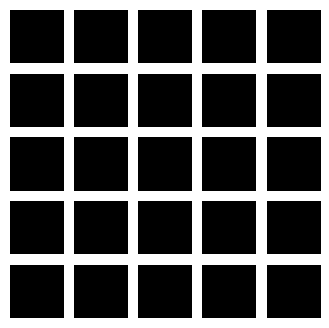

In [33]:
%timeit
n_epoches=5
is_train=True
if is_train==True:
    train(normalized_ds, n_epoches)

In [34]:
enc.load_weights('./tf_vae/anime/training_weights/enc_'+str(n_epoches-1)+'.h5')

In [35]:
dec.load_weights('./tf_vae/anime/training_weights/dec_'+str(n_epoches-1)+'.h5')

In [36]:
reconstruction_shape = 1000

In [37]:
embeddings = None
mean = None
var = None
for i in normalized_ds:
    m,v = enc.predict(i)
    embed = final.predict([m,v])
    #embed = dec.predict(latent)
    if embeddings is None:
        embeddings = embed
        mean = m
        var = v
    else:
        embeddings = np.concatenate((embeddings, embed))
        mean = np.concatenate((mean, m))
        var = np.concatenate((var, v))
    if embeddings.shape[0] > reconstruction_shape:
        break

4/4 [==============================] - 0s 2ms/step


In [38]:
embeddings.shape

(1024, 200)

## Latent Space Projection with t-SNE of VAE Trained on Cartoon Set

In [40]:
n_to_show = 5000
grid_size = 15
figsize = 12

tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate=100)
X_tsne = tsne.fit_transform(embeddings)
min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])


plt.figure(figsize=(figsize, figsize))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=10)
plt.ylabel("Dimension-2", size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.title("VAE - Projection of 2D Latent-Space (Anime Set)", size=20)
plt.show()

ValueError: ignored

In [41]:
reconstruction = None
lat_space = None
for i in normalized_ds:
    m,v = enc.predict(i)
    latent = final([m,v])
    out = dec.predict(latent)
    if reconstruction is None:
        reconstruction = out
        lat_space = latent
    else:
        reconstruction = np.concatenate((reconstruction, out))
        lat_space = np.concatenate((lat_space, latent))
    if reconstruction.shape[0] > reconstruction_shape:
        break

4/4 [==============================] - 0s 6ms/step


In [42]:
reconstruction.shape

(1024, 256, 256, 3)

## Reconstructing Test Images

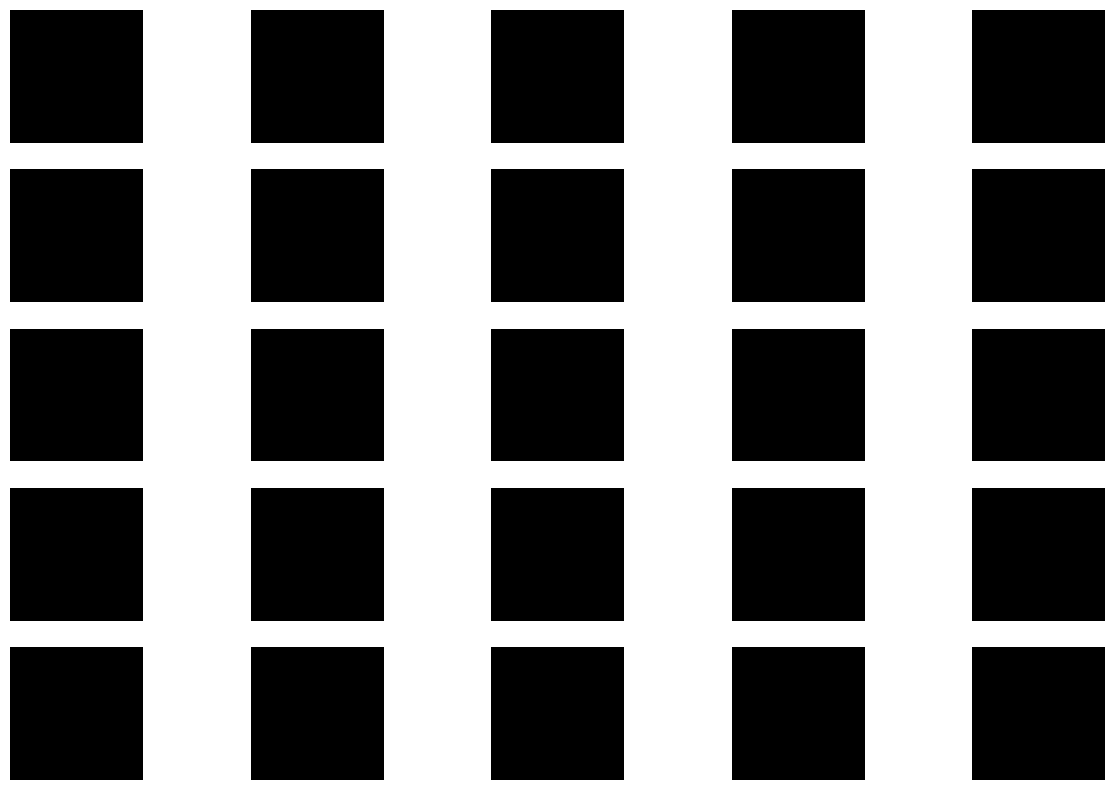

In [43]:
figsize = 15


fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruction[i, :, :, :] * 255
    pred = np.array(pred)
    pred = pred.astype(np.uint8)

    ax.imshow(pred)

## Reconstructing Anime Images from a Latent-Vector Sampled with Normal Distribution

1/1 [==============================] - 0s 348ms/step


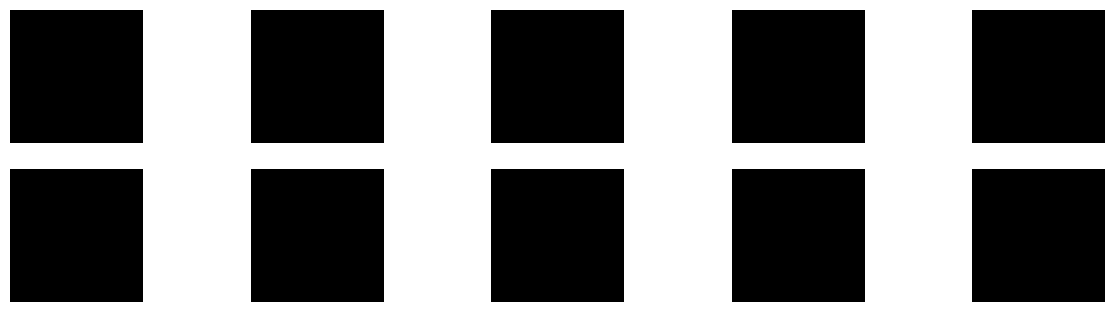

In [44]:
figsize = 15


x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

2/2 [==============================] - 0s 212ms/step


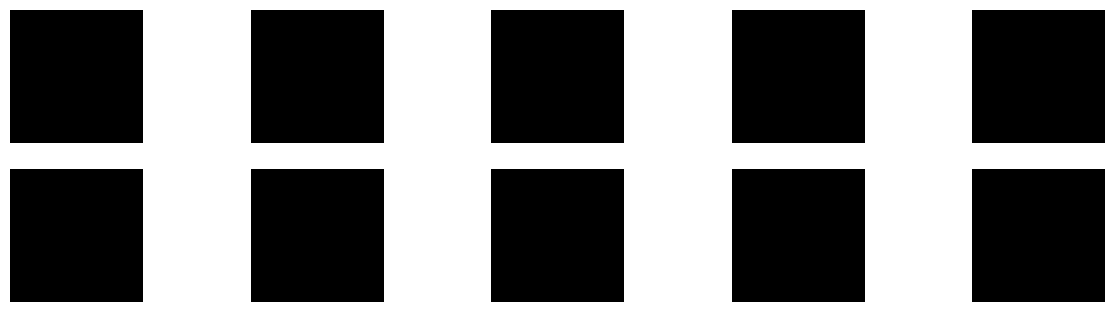

In [45]:
figsize = 15
x = np.random.exponential(scale=0.7, size = (50,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

## Reconstructing Cartoon Images with Latent-Vector Samples from different ranges

1/1 [==============================] - 0s 22ms/step


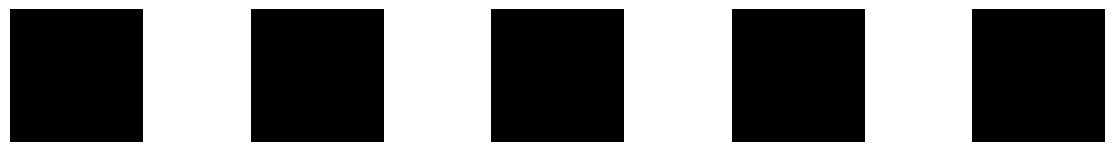

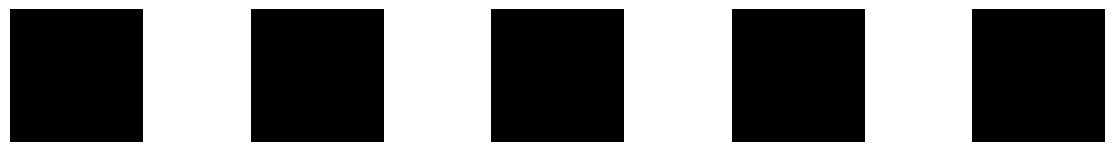

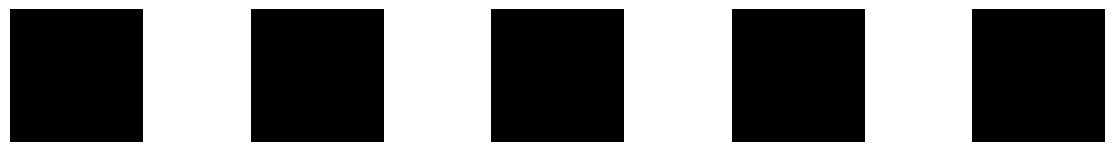

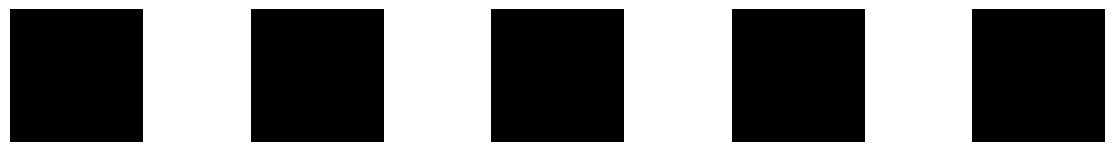

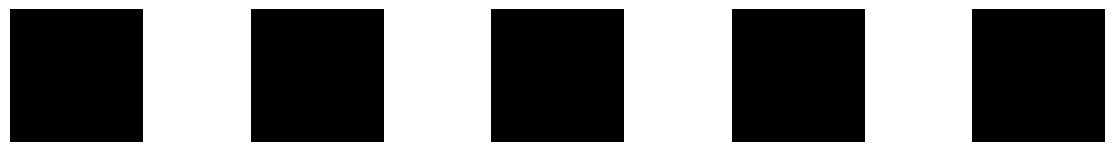

In [46]:
figsize = 15

for var_factor in range(-2, 3, 1):
    min_x = lat_space.min(axis=0)
    max_x = lat_space.max(axis=0)
    x = np.random.uniform(size = (10,200))
    x = x * (max_x - (np.abs(min_x))) + var_factor
    #print("value "+str(var_factor))
    reconstruct = dec.predict(x)


    fig = plt.figure(figsize=(figsize, 10))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    fig.set_label("value "+str(var_factor))

    for i in range(5):
        ax = fig.add_subplot(5, 5, i+1)
        ax.axis('off')
        pred = reconstruct[i, :, :, :] * 255
        pred = np.array(pred)
        pred = pred.astype(np.uint8)
        ax.imshow(pred)

In [47]:
#!pip uninstall tensorflow-io
!pip install --upgrade --no-deps --force-reinstall tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 64.1 MB/s eta 0:00:00


In [48]:
#!pip install --upgrade --no-deps --force-reinstall tensorflow-io

In [49]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.image import resize
import numpy as np
from scipy.linalg import sqrtm

# Download ResNet50 model
resnet_model = ResNet50(include_top=False, pooling='avg', input_shape=(224,224,3))

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_inception_score(p_yx, eps=1E-16):
    p_y = np.expand_dims(np.mean(p_yx, axis=0), 0)
    kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
    sum_kl_d = kl_d.sum(axis=1)

    avg_kl_d = np.mean(sum_kl_d)
    is_score = np.exp(avg_kl_d)
    return is_score

# You will need to replace these with your own image tensors.
# x_input are the input images and x_output are the output images from autoencoder

x_input = np.array(original_images)
x_output = np.array(reconstructed_images)

x_input_resized = resize(x_input, (224,224))
x_output_resized = resize(x_output, (224,224))

# Compute IS and FID
act1 = resnet_model.predict(x_input_resized)
act2 = resnet_model.predict(x_output_resized)

# compute inception score
p_yx = np.exp(act2)
is_score = calculate_inception_score(p_yx)

# compute frechet inception distance
fid_score = calculate_fid(act1, act2)

print(f"Inception Score: {is_score} FID Score: {fid_score}")


18/18 [==============================] - 0s 15ms/step


ValueError: ignored

In [50]:
from functools import lru_cache
#######################################################################################################################
#### First Potential Score ############################################################################################
#######################################################################################################################

def encoder(input_shape, conv_layers, filters = [128,128, 64, 32, 32]):
    inputs = keras.Input(shape=input_shape, name='input_layer')

    x = inputs
    for i in range(conv_layers):
        x = layers.Conv2D(filters[i], kernel_size=3, strides= 2, padding='same', name=f'conv_{i+1}')(x)
        x = layers.BatchNormalization(name=f'bn_{i+1}')(x)
        x = layers.LeakyReLU(name=f'lrelu_{i+1}')(x)
        if i % 2 == 1:  # Adding dropout after every 2nd layer for example
            x = layers.Dropout(0.2)(x)

    flatten = layers.Flatten()(x)
    mean = layers.Dense(200, name='mean')(flatten)
    log_var = layers.Dense(200, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

def decoder(input_shape, conv_layers, filters = [32, 32, 64, 128, 128]):
    inputs = keras.Input(shape=input_shape, name='input_layer')

    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8,8,64), name='Reshape')(x)

    for i in range(conv_layers):
        x = layers.Conv2DTranspose(filters[i], kernel_size=3, strides= 2, padding='same', name=f'conv_transpose_{i+1}')(x)
        x = layers.BatchNormalization(name=f'bn_{i+1}')(x)
        x = layers.LeakyReLU(name=f'lrelu_{i+1}')(x)
        if i % 2 == 1:  # Adding dropout after every 2nd layer for example
            x = layers.Dropout(0.2)(x)

    outputs = layers.Conv2DTranspose(filters[-1], 3, 2,padding='same', activation='sigmoid', name='conv_transpose_out')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model


def get_optimizer(optimizer_type,lr):
    #choosing a not so fast learning rate but also not super slow, dont have the time to experiment with different learning
    #rates
    if optimizer_type == 0:
        return tf.keras.optimizers.legacy.Adam(learning_rate =lr)
    elif optimizer_type == 1:
        return tf.keras.optimizers.legacy.SGD(learning_rate = lr)
    elif optimizer_type == 3:
        return tf.keras.optimizers.legacy.AdamW(learning_rate=lr)
    elif optimizer_type == 2:
        return tf.keras.optimizers.legacy.Nadam(learning_rate=lr)
    elif optimizer_type == 4:
        return tf.keras.optimizers.legacy.Yogi(learning_rate=lr)


def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_inception_score(p_yx, eps=1E-16):
    p_y = np.expand_dims(np.mean(p_yx, axis=0), 0)
    kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
    sum_kl_d = kl_d.sum(axis=1)

    avg_kl_d = np.mean(sum_kl_d)
    is_score = np.exp(avg_kl_d)
    return is_score
'''
def decoder(input_shape, dense_units=4096, conv_layer_params=[(32, 2), (64, 2), (64, 2), (128, 2)]):
    inputs = keras.Input(shape=input_shape, name='input_layer')
    x = layers.Dense(dense_units, name='dense_1')(inputs)
    x = layers.Reshape((8,8,64), name='Reshape')(x)

    for i, (filters, strides) in enumerate(conv_layer_params):
        x = layers.Conv2DTranspose(filters, 3, strides=strides, padding='same', name=f'conv_transpose_{i + 1}')(x)
        x = layers.BatchNormalization(name=f'bn_{i + 1}')(x)
        x = layers.LeakyReLU(name=f'lrelu_{i + 1}')(x)

    outputs = layers.Conv2DTranspose(3, 3, 2, padding='same', activation='sigmoid', name='conv_transpose_output')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model
'''

'\ndef decoder(input_shape, dense_units=4096, conv_layer_params=[(32, 2), (64, 2), (64, 2), (128, 2)]):\n    inputs = keras.Input(shape=input_shape, name=\'input_layer\')\n    x = layers.Dense(dense_units, name=\'dense_1\')(inputs)\n    x = layers.Reshape((8,8,64), name=\'Reshape\')(x)\n\n    for i, (filters, strides) in enumerate(conv_layer_params):\n        x = layers.Conv2DTranspose(filters, 3, strides=strides, padding=\'same\', name=f\'conv_transpose_{i + 1}\')(x)\n        x = layers.BatchNormalization(name=f\'bn_{i + 1}\')(x)\n        x = layers.LeakyReLU(name=f\'lrelu_{i + 1}\')(x)\n\n    outputs = layers.Conv2DTranspose(3, 3, 2, padding=\'same\', activation=\'sigmoid\', name=\'conv_transpose_output\')(x)\n    model = tf.keras.Model(inputs, outputs, name="Decoder")\n    return model\n'

In [ ]:
for i in range (4, 5): #the number of layers
  for j in range(3): #the corresponding optimizer
    #enc = encoder(input_encoder, i)
    #enc.summary()
    enc = encoder(input_encoder)

    input_1 = (200,)
    input_2 = (200,)

    final = sampling(input_1,input_2)
    stringName = "sampling-anime-"+str(i)+"-leakyReLU-"+str(j)+".h5"
    #strName
    final.save('sampling-anime.h5')
    #final.save(strName)

    dec = decoder(input_decoder)
    #dec.summary()
    if i == 0:
      optimizer = get_optimizer(j, 0.001)
    else:
      optimizer = get_optimizer(j, 0.01)

    # Initialize the lists that will store the images
    original_images = []
    reconstructed_images = []
    '''
    maybe change this for the epoch to be better


    # Training loop
    def train(dataset, epochs):
        for epoch in range(epochs):
            start = time.time()
            i = 0
            loss_ = []
            for image_batch in dataset:
                i += 1
                loss = train_step(image_batch)
                loss_.append(loss)

                # Here we will store the original images and reconstructed images
                if i <= 1000:
                    mean, log_var = enc(image_batch, training=False)
                    latent = final([mean, log_var])
                    generated_images = dec(latent, training=False)

                    original_images.append(image_batch[0].numpy())
                    reconstructed_images.append(generated_images[0].numpy())

                # Rest of your training loop...
            #print("Loss",np.mean(loss_))
            seed = image_batch[:25]
            display.clear_output(wait=True)
            generate_and_save_images([enc,final,dec],
                                      epoch + 1,
                                      seed)
            # Save the model every 15 epochs
            #if (epoch + 1) % 15 == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)
            enc.save_weights('tf_vae/anime/training_weights/enc_'+ str(epoch)+"-"+i+'-leaky-'+j+'.h5')
            dec.save_weights('tf_vae/anime/training_weights/dec_'+ str(epoch)+"-"+i+'-leaky-'+j+'.h5')
            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

            # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images([enc,final,dec],
                                epochs,
                                seed)

    '''

    n_epoches=20
    is_train=True
    if is_train==True:
        #train(normalized_ds, n_epochs, batch_size, get_optimizer("ftr"))
        train(normalized_ds, n_epoches)




    enc.load_weights('./tf_vae/anime/training_weights/enc_'+str(n_epoches-1)+'.h5')




    dec.load_weights('./tf_vae/anime/training_weights/dec_'+str(n_epoches-1)+'.h5')
    reconstruction_shape = 1000


    x_input = np.array(original_images)
    x_output = np.array(reconstructed_images)

    x_input_resized = resize(x_input, (224,224))
    x_output_resized = resize(x_output, (224,224))

    # Compute IS and FID
    act1 = resnet_model.predict(x_input_resized)
    act2 = resnet_model.predict(x_output_resized)

    # compute inception score
    p_yx = np.exp(act2)
    is_score = calculate_inception_score(p_yx)

    # compute frechet inception distance
    fid_score = calculate_fid(act1, act2)

    print(f"{stringName} Score of Inception Score: {is_score}, FID Score: {fid_score}")

    #print(f"Score of Inception Score: {is_score}, FID Score: {fid_score}")

    #Image 1
    embeddings = None
    mean = None
    var = None
    for i in normalized_ds:
        m,v = enc.predict(i)
        embed = final.predict([m,v])
        #embed = dec.predict(latent)
        if embeddings is None:
            embeddings = embed
            mean = m
            var = v
        else:
            embeddings = np.concatenate((embeddings, embed))
            mean = np.concatenate((mean, m))
            var = np.concatenate((var, v))
        if embeddings.shape[0] > reconstruction_shape:
            break

    n_to_show = 5000
    grid_size = 15
    figsize = 12

    tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate=100)
    X_tsne = tsne.fit_transform(embeddings)
    min_x = min(X_tsne[:, 0])
    max_x = max(X_tsne[:, 0])
    min_y = min(X_tsne[:, 1])
    max_y = max(X_tsne[:, 1])


    plt.figure(figsize=(figsize, figsize))
    plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
    plt.xlabel("Dimension-1", size=10)
    plt.ylabel("Dimension-2", size=10)
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.title("VAE - Projection of 2D Latent-Space (Anime Set)", size=20)
    plt.show()

    reconstruction = None
    lat_space = None
    for i in normalized_ds:
        m,v = enc.predict(i)
        latent = final([m,v])
        out = dec.predict(latent)
        if reconstruction is None:
            reconstruction = out
            lat_space = latent
        else:
            reconstruction = np.concatenate((reconstruction, out))
            lat_space = np.concatenate((lat_space, latent))
        if reconstruction.shape[0] > reconstruction_shape:
            break


    ###Image 2
    figsize = 15


    fig = plt.figure(figsize=(figsize, 10))

    for i in range(25):
        ax = fig.add_subplot(5, 5, i+1)
        ax.axis('off')
        pred = reconstruction[i, :, :, :] * 255
        pred = np.array(pred)
        pred = pred.astype(np.uint8)

        ax.imshow(pred)

    #image 3
    figsize = 15


    x = np.random.normal(size = (10,200))
    reconstruct = dec.predict(x)


    fig = plt.figure(figsize=(figsize, 10))
    #image 4
    for i in range(10):
        ax = fig.add_subplot(5, 5, i+1)
        ax.axis('off')
        pred = reconstruct[i, :, :, :] * 255
        pred = np.array(pred)
        pred = pred.astype(np.uint8)
        ax.imshow(pred)

    figsize = 15
    x = np.random.exponential(scale=0.7, size = (50,200))
    reconstruct = dec.predict(x)


    fig = plt.figure(figsize=(figsize, 10))
    #image 4
    for i in range(10):
        ax = fig.add_subplot(5, 5, i+1)
        ax.axis('off')
        pred = reconstruct[i, :, :, :] * 255
        pred = np.array(pred)
        pred = pred.astype(np.uint8)
        ax.imshow(pred)

    figsize = 15

    #image 5
    for var_factor in range(-2, 3, 1):
        min_x = lat_space.min(axis=0)
        max_x = lat_space.max(axis=0)
        x = np.random.uniform(size = (10,200))
        x = x * (max_x - (np.abs(min_x))) + var_factor
        #print("value "+str(var_factor))
        reconstruct = dec.predict(x)


        fig = plt.figure(figsize=(figsize, 10))
        fig.subplots_adjust(hspace=0.2, wspace=0.2)
        fig.set_label("value "+str(var_factor))

        for i in range(5):
            ax = fig.add_subplot(5, 5, i+1)
            ax.axis('off')
            pred = reconstruct[i, :, :, :] * 255
            pred = np.array(pred)
            pred = pred.astype(np.uint8)
            ax.imshow(pred)




In [ ]:
tf.keras.backend.clear_session()